# Practice 1 : Reading GK2A
- 2023.11.21.Tue

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
##!apt-get -qq install libgeos-dev
# !pip install netCDF4
# !pip install --upgrade -q pyproj
# !pip install basemap
## !apt-get install libgeos-3.5.0
## !apt-get install libgeos-dev
## !pip install https://github.com/matplotlib/basemap/archive/master.zip

## GK-2A NetCDF 파일 읽기 (적외 채널)
### 파이썬 서브 코드 세팅
1. 입력되는 관측영역과 채널에 번호에 따라 x와 y 배열수, 해상도, 그리고 지역 할당
2. Digital Number를 Brightness Temperature로 복사변환
3. 각 채널 파장 대역에 따른 Brightness Temperature(BT) 출력 (`PPT 자료 확인`) 

In [2]:
# ==============================================================================================
# 1. GK-2A/AMI Read DIM
# ==============================================================================================
def Read_DIM(area, ch_num):
   if (area=='fd'): # fd: full disk
     if((ch_num==1) | (ch_num==2) | (ch_num==4)):   
       # B,G, infrared channel
       # nm_area : 0 -> Full-disk, 1 -> CN, res=1 is 1km
       xdim=11000 # distance of full disk : x axis dimension
       ydim=11000 # y dimension
       res=1 # 1km (resolution)
       nm_area=0 # Full disk
     elif(ch_num==3):
       # Red channel
       xdim=22000 # x dimension
       ydim=22000 # y dimension
       res=0.5  # 0.5 km
       nm_area=0 # Full disk
     elif((ch_num==5) | (ch_num==6)):
      # 1.3, 1.6 infra red channel 
       xdim=5500
       ydim=5500
       res=2 # 2 km
       nm_area=0 # Full disk
   return xdim, ydim, res, nm_area

#### GK2A DN to Brightnee Temperature 변환 수행 함수 
- 정수형 DN 값을 물리적 값으로 변환


In [3]:
# ==============================================================================================
# 2. GK-2A/AMI DN to Brightness Temperature
# ==============================================================================================
# NetCDF 객체(D) 입력, 채널(ch) 입력 받는 함수
# 입력값에 대한 NetCDF 파일 읽기 수행
def DN2BT(D, ch):
   import numpy as np
   from netCDF4 import Dataset
   import netCDF4 as nc
   import math
   
   #  GK2A NetCDF에 포함하는 변수 확인
   # Variables(변수) 출력
#   print("Variables(변수):")
#   for var in D.variables:
#      print(var)

   # Attributes(속성) 출력
   print("Attributes(속성):")
   for attr in D.ncattrs():
      print(attr, ":", getattr(D, attr))

   # NetCDF에서 배열과 복사변환 계수를 입력
   row = D.getncattr('number_of_lines') # y값
   col = D.getncattr('number_of_columns') # x값 
      # 채널마다 row, col가 다르기때문에 주의해야함! 여기서는 full disk 라 같지만,, 
   gain = D.getncattr('DN_to_Radiance_Gain')
   offset = D.getncattr('DN_to_Radiance_Offset')
      # y = ax +b 
      # y = radiance, x = digital number
      # a = gain , b = offset 
   
   # NetCDF에서 GK-2A DN 값 입력
   gk2a_dn=np.array(D.variables['image_pixel_values'])  # digital number
   gk2a_rad = gk2a_dn*gain+offset   # y = a*x + b
   # GK-2A Bad value에 대해서 -128로 할당 (signed integer로 변환)
   gk2a_rad[gk2a_dn==32768]=-128. # digital number == 32768 인 값은 -128로 변환(nullvalue 처리를 위함. 국가기상위상센터에서의 방식)
# ----------------------------------------------------------------------------------------------
#  3. Setting Constants Variables
# ----------------------------------------------------------------------------------------------
   # 초기 배열 할당
   # 각각의 IR 채널 파장 중심 대역 입력
   lamda_ir = np.zeros(10) 
   lamda_ir[0]   =  3.82749133182218  # IR 3.830
   lamda_ir[1]   =  6.18196269968843  # IR 6.241
   lamda_ir[2]   =  6.93685519362696  # IR 6.952
   lamda_ir[3]   =  7.32466585491178  # IR 7.344
   lamda_ir[4]   =  8.58406387549677  # IR 8.592
   lamda_ir[5]   =  9.61575244772356  # IR 9.625
   lamda_ir[6]   = 10.35032342314430  # IR 10.403
   lamda_ir[7]   = 11.21436982235590  # IR 11.212
   lamda_ir[8]   = 12.33640374446540  # IR 12.354
   lamda_ir[9]   = 13.26980420792720  # IR 13.310

   wavenum_ir = np.zeros(10)
   wavenum_ir[0]  = 2612.677373521110
   wavenum_ir[1]  = 1617.609242531340
   wavenum_ir[2]  = 1441.575428760170
   wavenum_ir[3]  = 1365.249992024440
   wavenum_ir[4]  = 1164.949392856340
   wavenum_ir[5]  = 1039.960216776110
   wavenum_ir[6]  =  966.153383926055
   wavenum_ir[7]  =  891.713057301260
   wavenum_ir[8]  =  810.609007871230
   wavenum_ir[9]  =  753.590621482278

   planck_c    = D.getncattr('Plank_constant_h')
   light_speed = D.getncattr('light_speed')
   boltz_c     = D.getncattr('Boltzmann_constant_k')
   coef_c0     = D.getncattr('Teff_to_Tbb_c0')
   coef_c1     = D.getncattr('Teff_to_Tbb_c1')
   coef_c2     = D.getncattr('Teff_to_Tbb_c2')
  
   # DN to Brightnee temperature 계산식 （강의자료 ＰＰＴ） 참조
   c1 = 2.0 * planck_c * light_speed * light_speed 
   c2 = (planck_c * light_speed) / boltz_c
   # \ => 줄 연장 연산자
   rad_tmp = c2 * ( wavenum_ir[ch] * 100. ) / \
            ( np.log( (c1 * (wavenum_ir[ch] * 100.)**3) / (gk2a_rad * 1.E-5) + 1.) )
   gk2a_bt = coef_c0 + coef_c1 * rad_tmp + coef_c2 * rad_tmp**2   # 최종적으로 비트값을 얻는다. 

   gk2a_bt[gk2a_dn==32768]=-128.

   return gk2a_bt

In [4]:
# ==============================================================================================
# GK-2A/AMI Read 2km (BT)
# ==============================================================================================
# ２ｋｍ 공간 해상도로 y 배열, x 배열, GK-2A 자료, 채널 번호
def READBT2KM(ydims, xdims, gk2a_ch_fn_2km, ch_nm):
  import numpy as np
  from netCDF4 import Dataset
  import netCDF4 as nc
  
  # np.zerofdfs를 이용하여 numpy 2차원 배열 실수형 자료 선언
  gk2a_ch_bt_2km = np.zeros([ydims,xdims],dtype=np.float32)

  # gk2a_ch_fn_2km 파일 크기는 출력 #############
  f'the size of gk2a_ch_fn_2km file {os.path.getsize(gk2a_ch_fn_2km)}' # 
  if os.path.getsize(gk2a_ch_fn_2km) != 0:
    # NetCDF 객체 읽기
    D = Dataset(gk2a_ch_fn_2km, mode='r')
    # GK2A Digital Number to Brightness Temperature function 사용
    gk2a_ch_bt_2km = DN2BT(D, ch_nm)
    # 16bit(2byte) 정수형 자료를 실수형으로 변환
  gk2a_ch_bt_2km = gk2a_ch_bt_2km.astype(np.float32)
  #print('[Reading Complete]', gk2a_ch_fn_2km)
  return gk2a_ch_bt_2km

# ==============================================================================================
# GK-2A/AMI Image 생성 수행
# ==============================================================================================
#           GK2A, 128.2, output_path directory, output file name
# BT2IMAGE(gk2a_ch11_bt_2km, 128.2, opath_img, out_nm_ch11)
def BT2IMAGE(data, lon_info, opath_info, output_nm):
  from mpl_toolkits.basemap import Basemap
  import matplotlib.pyplot as plt
  import pylab

  lon_0 = lon_info # 128.2
  # Basemap의 Resolution 인자는 지도의 세부 사항을 결정
  m1 = Basemap(projection='geos',lon_0=lon_0, resolution=None) # 
  
  # 0 보다 작은 값에 대해서 Mask 처리
  nbar=ma.masked_where((data < 0)  ,data)
  # geos= geostationary 투영법
  # lon_0 = 기준 경도
  # resolution = 지도해상도 (intermediate)
  # area_thresh = 지도 세부사항 임계값 (10000 : 100km X 100km 이하 호수,섬은 X)
  # rsphere=지구의 반지름을 설정. 적도 반지름(6378137.0), 극 반지름(6356752.3)
  map = Basemap(projection='geos',lon_0=lon_0,resolution='i', \
                area_thresh=10000., satellite_height=35785863.0, \
                rsphere=(6378137.0 , 6356752.3 ), \
                llcrnrx = -5499999.901174725, llcrnry = -5499999.901174725, \
                urcrnrx = 5499999.901174725, urcrnry = 5499999.901174725)

  map.drawcoastlines(linewidth=0.5) # 해안선 두께
  map.drawcountries(linewidth=0.5, color='k') # 국경선 두께와 색
  map.drawparallels(np.arange(-90.,90.,20)) # 위도선 -90~+90 20도 간격
  map.drawmeridians(np.arange(-180.,180.,20)) # 경도선
  # origin='uuper' 이미지의 LeftUpper가 (0,0)                                            
  # map.imshow(nbar, interpolation='nearest', origin='upper', cmap=matplotlib.colormaps.get_cmap('jet'), vmin=200., vmax=350.)  ## min, max
  #### 위 코드가 에러나서 아래 코드로 수정했었음 
  map.imshow(nbar, interpolation='nearest', origin='upper', cmap=plt.get_cmap('jet'), vmin=200., vmax=350.) # value = kelvin의 min,max값 세팅

  # 컬러바 추가 코드, size=5%는 컬러바 너비, pad는 지도와 colorbar 간격 (5%)
  cbar = m1.colorbar(size="5%", pad = 0.05)
  cbar.set_label('Brightness Temperature [K]')
  plt.title(output_nm, fontsize=13, y=1.01)
  plt.axis('on')    ##  'on ' have edge line / 'off' have no edge line
  plt.savefig(opath_info+output_nm+'.png', dpi=300, bbox_inches='tight')
  plt.show()        ## Show the output image before saving
  plt.close('all')

  print('[Imaging Complete] :', output_nm)


print("[Setting sub code] Complete")

[Setting sub code] Complete


파이썬 라이브러리 세팅

In [1]:
from netCDF4 import Dataset
import netCDF4 as nc
import numpy as np
import glob, os
import math
from pylab import *   # matplotlib를 설치할 때 같이 설치되는 모듈 (pyplot으로 대체될 듯)

GK-2A 자료입출력 디렉토리 경로 설정

In [5]:
# input 디렉토리 (home directory)
ipath        = "/home/student/SL2023/data/"
# GK-2A 채널 자료
ipath_l1b    = ipath+"input_data1/channel/"
ipath_latlon = ipath+"input_data1/latlon/"
ipath_lsmask = ipath+"input_data1/lsmask/"

opath = ipath+"output_01_bin/"
if not os.path.exists(opath): os.mkdir(opath)
opath_img = opath+"img/"
if not os.path.exists(opath_img): os.mkdir(opath_img)

변수 설정

In [19]:
#-------------------------------------------------------------------------------
# 날짜 설정 (일반적으로는 파일 이름에서 가져옴)
date = "202103290300"
yy = date[0:4]
mm = date[4:6]
dd = date[6:8]
hh = date[8:10]
mn = date[10:12]
gk2a_date = yy+mm+dd+hh+mn
print("[GK-2A/AMI Scene Information] :", gk2a_date)

#-------------------------------------------------------------------------------
# 상수 설정 (GK-2A IR 채널 읽기 용)
# 1km 채널과 red 500m을 읽을 때는 다른 상수 적용필요 => 추후 파일 명에서 자동 입력
xdims_020= 5500 ; ydims_020= 5500 ; res_020=2

[GK-2A/AMI Scene Information] : 202103290300


천리안위성 2호 위도, 경도, 육상/해상 마스크 정보 읽기

In [20]:
# 위도, 경도, Landsea mask 파일 (Binary with fromfile) 읽기 
gk2a_lat_2km    = np.fromfile(ipath_latlon+'Lat_2km.bin',dtype=np.float32).reshape(5500,5500)   #binary file을 읽는 numpy function 
gk2a_lon_2km    = np.fromfile(ipath_latlon+'Lon_2km.bin',dtype=np.float32).reshape(5500,5500)
gk2a_lsmask_2km = np.fromfile(ipath_lsmask+'lsmask_2km.bin',dtype=np.int16).reshape(5500,5500)
print("[Reading complete] : GK-2A/AMI Latitude, Longitude, Land/Sea Mask")

[Reading complete] : GK-2A/AMI Latitude, Longitude, Land/Sea Mask


천리안위성 2호 Channel 자료 읽기

- /media/data2/cy/SL2023/project4_team_project/data/2020
- mean_2020_087.nc  
- mean_2020_105.nc  
- mean_2020_123.nc

Attributes(속성):
satellite_name : GK-2A
instrument_name : AMI
data_processing_center : NMSC
data_processing_mode : operation
channel_spatial_resolution : 2.0
channel_center_wavelength : 8.7
scene_acquisition_time : 20210329_030033
mission_reference_time : 20210329_030000
file_generation_time : 20210329_031008
file_name : gk2a_ami_le1b_ir087_fd020ge_202103290300.nc
file_format_version : 1.0.0_20181120
geometric_correction_sw_version : GK2_INRSM_V1.3
star_catalog_version : 1.0.0_20170303
landmark_catalog_version : 1.0.0_20190502
calibration_table_version : v.3.0_20190415
DN_to_Radiance_Gain : -0.0144806550815701
DN_to_Radiance_Offset : 118.050903320312
Teff_to_Tbb_c0 : -0.141418528203155
Teff_to_Tbb_c1 : 1.00052232906885
Teff_to_Tbb_c2 : -3.6287276076109e-07
light_speed : 299792458.0
Plank_constant_h : 6.62606957e-34
Boltzmann_constant_k : 1.3806488e-23
total_pixel_data_size : 60500000
number_of_total_swaths : 23
number_of_columns : 5500
number_of_lines : 5500
observation_mode : FD
observ

/home/student/anaconda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log


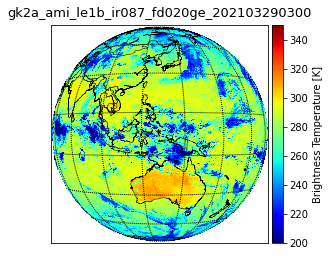

[Imaging Complete] : gk2a_ami_le1b_ir087_fd020ge_202103290300
Attributes(속성):
satellite_name : GK-2A
instrument_name : AMI
data_processing_center : NMSC
data_processing_mode : operation
channel_spatial_resolution : 2.0
channel_center_wavelength : 10.5
scene_acquisition_time : 20210329_030033
mission_reference_time : 20210329_030000
file_generation_time : 20210329_031008
file_name : gk2a_ami_le1b_ir105_fd020ge_202103290300.nc
file_format_version : 1.0.0_20181120
geometric_correction_sw_version : GK2_INRSM_V1.3
star_catalog_version : 1.0.0_20170303
landmark_catalog_version : 1.0.0_20190502
calibration_table_version : v.3.0_20190415
DN_to_Radiance_Gain : -0.0198196955025196
DN_to_Radiance_Offset : 161.580139160156
Teff_to_Tbb_c0 : -0.142866448475177
Teff_to_Tbb_c1 : 1.00064069572049
Teff_to_Tbb_c2 : -5.50443294960498e-07
light_speed : 299792458.0
Plank_constant_h : 6.62606957e-34
Boltzmann_constant_k : 1.3806488e-23
total_pixel_data_size : 60500000
number_of_total_swaths : 23
number_of_co

/home/student/anaconda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log


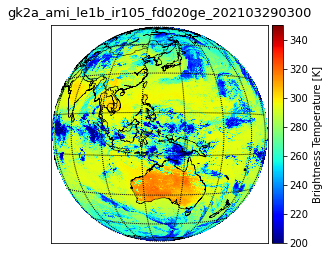

[Imaging Complete] : gk2a_ami_le1b_ir105_fd020ge_202103290300
Attributes(속성):
satellite_name : GK-2A
instrument_name : AMI
data_processing_center : NMSC
data_processing_mode : operation
channel_spatial_resolution : 2.0
channel_center_wavelength : 12.3
scene_acquisition_time : 20210329_030033
mission_reference_time : 20210329_030000
file_generation_time : 20210329_031008
file_name : gk2a_ami_le1b_ir123_fd020ge_202103290300.nc
file_format_version : 1.0.0_20181120
geometric_correction_sw_version : GK2_INRSM_V1.3
star_catalog_version : 1.0.0_20170303
landmark_catalog_version : 1.0.0_20190502
calibration_table_version : v.3.0_20190415
DN_to_Radiance_Gain : -0.023379972204566
DN_to_Radiance_Offset : 190.649627685546
Teff_to_Tbb_c0 : -0.458113885722738
Teff_to_Tbb_c1 : 1.00245520975535
Teff_to_Tbb_c2 : -2.53064314720476e-06
light_speed : 299792458.0
Plank_constant_h : 6.62606957e-34
Boltzmann_constant_k : 1.3806488e-23
total_pixel_data_size : 60500000
number_of_total_swaths : 23
number_of_col

/home/student/anaconda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log


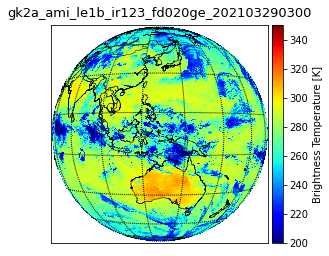

[Imaging Complete] : gk2a_ami_le1b_ir123_fd020ge_202103290300
[Reading complete] GK-2A/AMI Channel Data
All code complete


In [21]:
#-------------------------------------------------------------------------------
# 8.7 micrometer channel
gk2a_ch11_fn = ipath_l1b+'gk2a_ami_le1b_ir087_fd020ge_'+gk2a_date+'.nc'

# GK2A 위성 IR 채널 상수를 이용한 DN to Radiance, BT 자료 산출
gk2a_ch11_bt_2km = READBT2KM(ydims_020, xdims_020, gk2a_ch11_fn, 4) # 4는 8.7채널
out_nm_ch11 = 'gk2a_ami_le1b_ir087_fd020ge_'+gk2a_date
# GK2A 위성 IR BT자료를 이용한 이미지 출력 
BT2IMAGE(gk2a_ch11_bt_2km, 128.2, opath_img, out_nm_ch11)

#-------------------------------------------------------------------------------
# 10.5 micrometer channel
gk2a_ch13_fn = ipath_l1b+'gk2a_ami_le1b_ir105_fd020ge_'+gk2a_date+'.nc'
gk2a_ch13_bt_2km = READBT2KM(ydims_020, xdims_020, gk2a_ch13_fn, 6)
out_nm_ch13 = 'gk2a_ami_le1b_ir105_fd020ge_'+gk2a_date
BT2IMAGE(gk2a_ch13_bt_2km, 128.2, opath_img, out_nm_ch13)

#-------------------------------------------------------------------------------
# 12.4 micrometer channel
gk2a_ch15_fn = ipath_l1b+'gk2a_ami_le1b_ir123_fd020ge_'+gk2a_date+'.nc'
gk2a_ch15_bt_2km = READBT2KM(ydims_020, xdims_020, gk2a_ch15_fn, 8)
out_nm_ch15 = 'gk2a_ami_le1b_ir123_fd020ge_'+gk2a_date
BT2IMAGE(gk2a_ch15_bt_2km, 128.2, opath_img, out_nm_ch15)

print('[Reading complete] GK-2A/AMI Channel Data')
# 파일 출력을 위한 파일객체(f) 반환
# Numpy 배열이 gk2a_ch11_bt_2km를 이진 파일을 출력하는 tofile Numpy 메소드를 사용
## 계산이 다 된 값을 가지고 binary파일을 만든다. 
## nc file로도 만들 수 있음 
f = open(opath+"gk2a_ir087_"+gk2a_date+".bin", "w")
gk2a_ch11_bt_2km.tofile(f)  ; f.close()

f = open(opath+"gk2a_ir105_"+gk2a_date+".bin", "w")
gk2a_ch13_bt_2km.tofile(f)  ; f.close()

f = open(opath+"gk2a_ir124_"+gk2a_date+".bin", "w")
gk2a_ch15_bt_2km.tofile(f)  ; f.close()

print("All code complete")